In [30]:
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u
matplotlib.rcParams["figure.figsize"]=12,10
matplotlib.rcParams["font.size"] = 20
from astropy.table import Table, vstack, hstack


In [5]:
cat = fits.open('../plane_gaiadr2_dust_06_12_19.fits')[1].data
cga = Table.read('../plane_gaia_apo13_match_07_03_19.txt', format='ascii')

In [6]:
len(cga)

6829

In [35]:
cga.colnames

['solution_id',
 'source_id',
 'ra_gaia',
 'ra_error',
 'dec_gaia',
 'dec_error',
 'parallax',
 'parallax_error',
 'pmra',
 'pmdec',
 'visibility_periods_used',
 'duplicated_source',
 'phot_g_mean_flux',
 'phot_g_mean_flux_error',
 'phot_g_mean_mag',
 'phot_bp_mean_flux',
 'phot_bp_mean_flux_error',
 'phot_bp_mean_mag',
 'phot_rp_mean_flux',
 'phot_rp_mean_flux_error',
 'phot_rp_mean_mag',
 'radial_velocity',
 'radial_velocity_error',
 'rv_template_teff',
 'rv_template_logg',
 'rv_template_fe_h',
 'phot_variable_flag',
 'teff_val',
 'flame_flags',
 'angsep',
 'number_plane',
 'NUMBER',
 'X_IMAGE',
 'Y_IMAGE',
 'ra_plane',
 'dec_plane',
 'FLUX_AUTO',
 'FLUXERR_AUTO',
 'FLUX_APER',
 'A_IMAGE',
 'B_IMAGE',
 'THETA_IMAGE',
 'FWHM_IMAGE',
 'nuv',
 'gl',
 'gb',
 'expsum',
 'ctsum',
 'bkgdsum',
 'dist',
 'distmod',
 'ebv',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'TEFF',
 'TEFF_ERR',
 'LOGG',
 'LOGG_ERR',
 'M_H',
 'M_H_ERR',
 'ALPHA_M',
 'ALPHA_M_ERR',

### Match Apogee 13 and UVGAPS

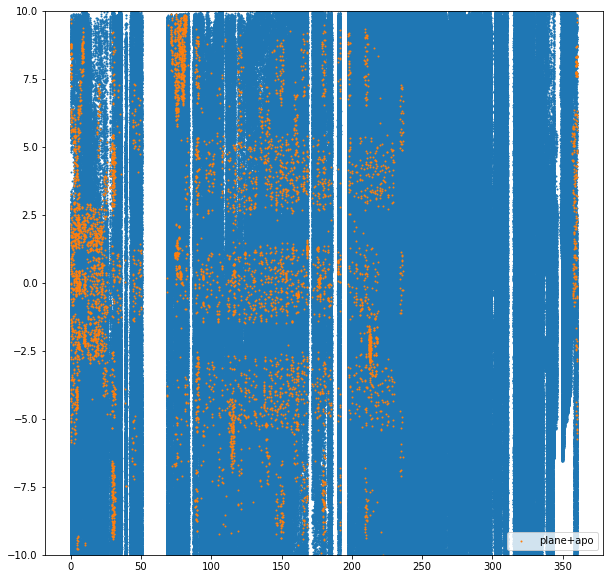

In [7]:
matplotlib.rcParams['figure.figsize'] = 10, 10
plt.scatter(cat['gl'], cat['gb'],s=1)
plt.scatter(cga['gl'], cga['gb'], s=1, label='plane+apo')
plt.legend(loc=4)
plt.ylim(-10, 10)
plt.show()

In [8]:
cuts = np.where(cga['FE_H'] > -10)
cga = cga[cuts]
len(cga)

1274

### Cross match includes MS objects, cut out before looking at RC

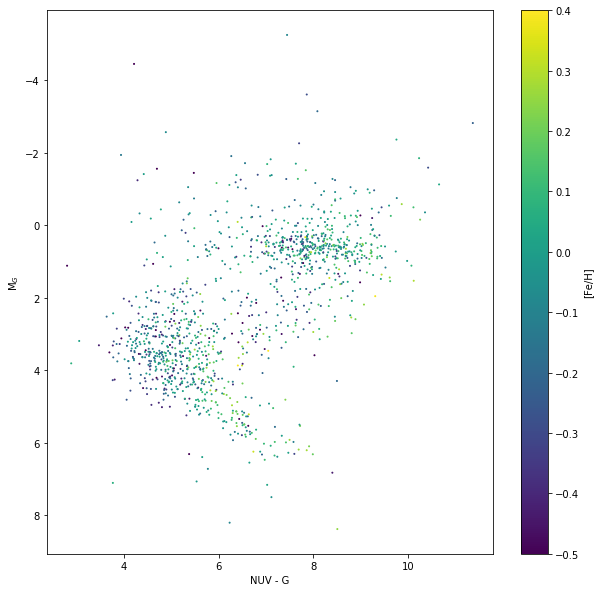

In [9]:
plt.scatter(cga['nuv']-cga['phot_g_mean_mag'], cga['phot_g_mean_mag']-cga['distmod'], c=cga['FE_H'], vmin=-0.5, vmax=.4, s=1)
plt.gca().invert_yaxis()
plt.xlabel('NUV - G')
plt.ylabel('M$_G$')
plt.colorbar().set_label('[Fe/H]')
plt.show()

#### Cut out MS objects with color-color cut

In [33]:
rccut = np.where(((cga['nuv']-cga['phot_g_mean_mag']) > 7) & (cga['phot_g_mean_mag']-cga['distmod'] < 2))
rc = cga[rccut]
len(rc)
aferc = rc['ALPHA_M'] + rc['M_H'] - rc['FE_H']
rc['alphafe'] = aferc

#### Fe/H vs NUV-G w/ and without dust correction

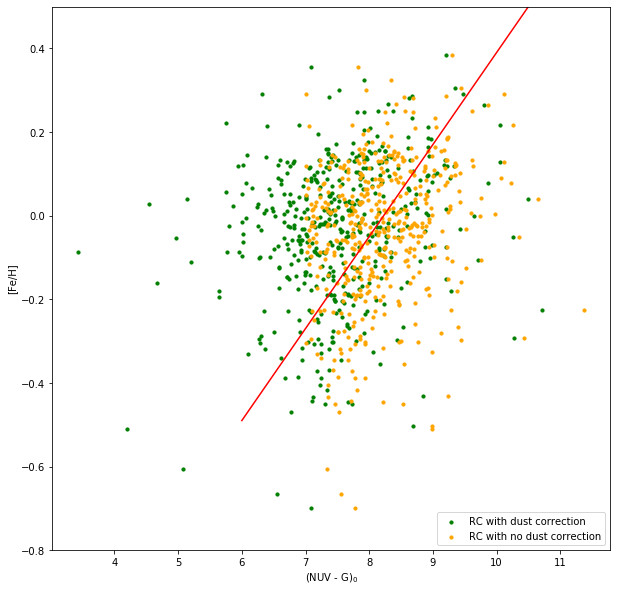

In [12]:
nuvgsamp = np.linspace(6, 10.5, 50)
fehsamp = 0.22*nuvgsamp - 1.81
#plt.scatter((cga['nuv']-cga['ebv']*7.24)-(cga['phot_g_mean_mag']-cga['ebv']*2.85), cga['FE_H'], s=1, label='All matches')
plt.scatter((rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85), rc['FE_H'], s=10, label='RC with dust correction', c='green')
plt.scatter((rc['nuv'])-(rc['phot_g_mean_mag']), rc['FE_H'], s=10, label='RC with no dust correction', c='orange')
plt.plot(nuvgsamp, fehsamp, c='red')
plt.xlabel('(NUV - G)$_0$')
plt.ylabel('[Fe/H]')
plt.ylim(-0.8, 0.5)
plt.legend(loc=4)
plt.show()

#### Apply relation from paper

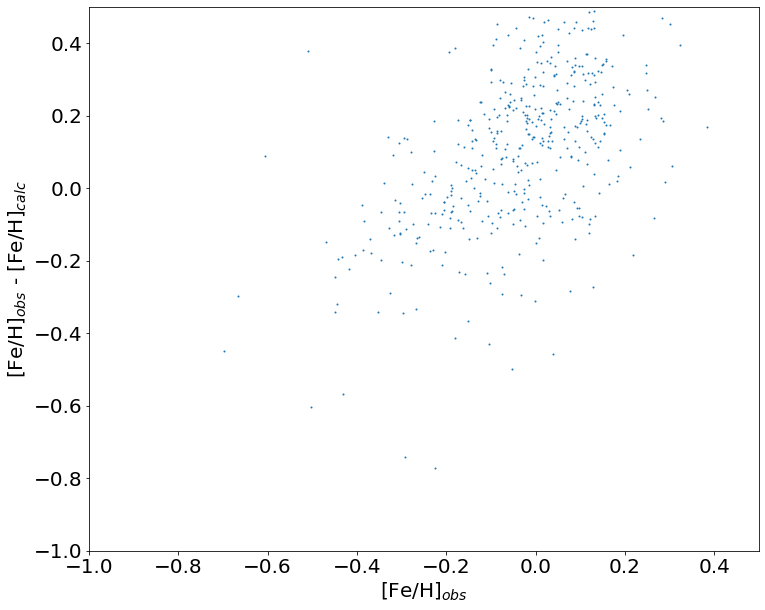

In [16]:
plt.scatter(rc['FE_H'], rc['FE_H']-(0.22*((rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85))-1.81), s=1)
plt.xlim(-1, 0.5)
plt.ylim(-1, 0.5)
plt.xlabel('[Fe/H]$_{obs}$')
plt.ylabel('[Fe/H]$_{obs}$ - [Fe/H]$_{calc}$')
plt.show()

#### Load in Plane + Ting table, reduce to only RC pristine sample

In [17]:
ting = Table.read('../plane_gaia_ting.txt', format='ascii')
print(len(ting))
t2 = ting[np.where(ting['Classification'] == 'RC_Pristine')]
afet = ting['ALPHA_M'] + ting['M_H'] - ting['Fe_H']
ting['alphafe'] = afet

511


#### Entire ting sample vs RC pristine subset

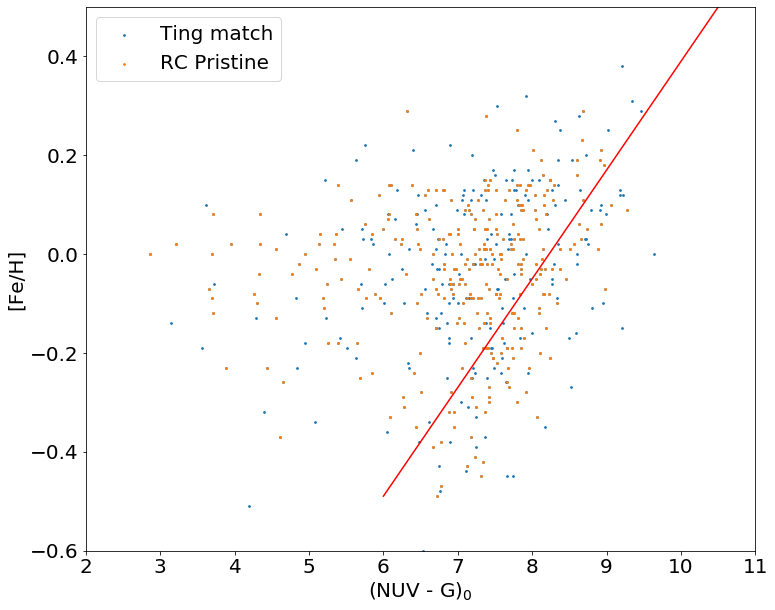

In [20]:
nuvgsamp = np.linspace(6, 10.5, 50)
fehsamp = 0.22*nuvgsamp - 1.81
plt.scatter((ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), ting['Fe_H'], s=3, label='Ting match')
plt.scatter((t2['nuv']-t2['ebv']*7.24)-(t2['phot_g_mean_mag_1']-t2['ebv']*2.85), t2['Fe_H'], s=3, label='RC Pristine')
plt.plot(nuvgsamp, fehsamp, c='red')
plt.xlabel('(NUV - G)$_0$')
plt.ylabel('[Fe/H]')
plt.xlim(2, 11)
plt.ylim(-0.6, 0.5)
plt.legend(loc=2)
plt.show()

#### These Ting RC stars are mostly all low alpha/Fe (thin disk) as expected 

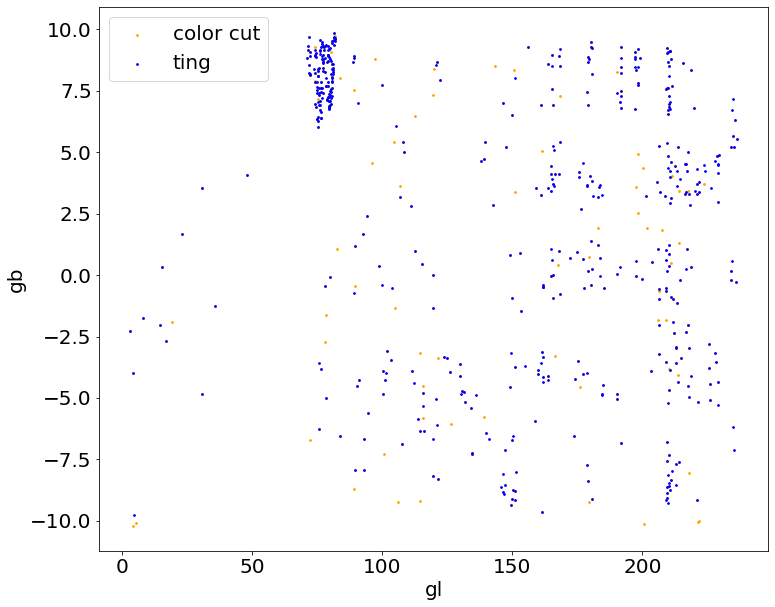

469
511


In [21]:
plt.scatter(rc['gl'], rc['gb'],s=3, color='orange', label='color cut')
plt.scatter(ting['gl'], ting['gb'],s=3, color='blue', label='ting')
plt.xlabel('gl')
plt.ylabel('gb')
plt.legend(loc=2)
plt.show()
print(len(rc))
print(len(ting))

##### rc = plane + apogee in rc space, ting = plane + ting. Now load in rcais = GAIS + ting


In [22]:
rcais = fits.open('../asc_gaia_aporc_match_dust-05-03-18.fits')[1].data
q = np.where((rcais['ebv'] > 0) & (rcais['Fe_H_err'] > 0) & (rcais['phot_bp_mean_mag'] > 0) & (rcais['phot_rp_mean_mag'] > 0) & (rcais['Classification'] == 'RC_Pristine') & (rcais['dist'] < 3500) & (rcais['visibility_periods_used'] > 8) & (rcais['parallax_error']/rcais['parallax'] < 0.1))
rcais2 = rcais[q]

In [27]:
rcgal = SkyCoord(rc['ra_gaia']*u.deg, rc['dec_gaia']*u.deg, frame='icrs')
tinggal = SkyCoord(ting['ra_gaia']*u.deg, ting['dec_gaia']*u.deg, frame='icrs')
rcaisgal = SkyCoord(rcais['RA']*u.deg, rcais['DEC']*u.deg, frame='icrs')

rc1ind, rcais1ind, angseprc, ang3d = search_around_sky(rcgal, rcaisgal, 1*u.arcsec)
tind, rcais2ind, angsept, ang3d = search_around_sky(tinggal, rcaisgal, 1*u.arcsec)
tind2, rc2ind, angseprct, ang3d = search_around_sky(tinggal, rcgal, 1*u.arcsec)

pais = hstack([rc[rc1ind], Table(rcais[rcais1ind])])
tais = hstack([ting[tind], Table(rcais[rcais2ind])])
tais.sort('ra_gaia')
pais.sort('ra_gaia')

trc = hstack([ting[tind2], rc[rc2ind]])

##### The two tables match the same 24 objects in GAIS. Only 12 have the RC_Pristine classification. Ting and the c-c cut RC have 400 matches 

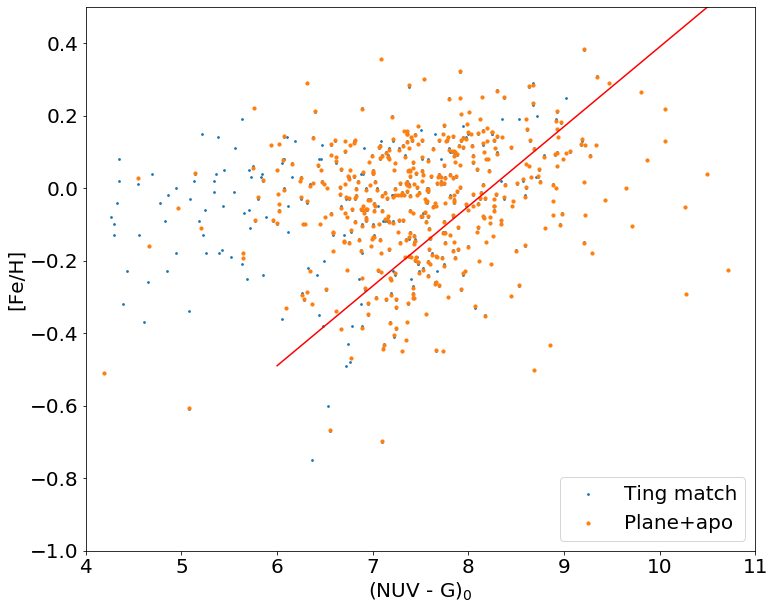

In [28]:
plt.scatter((ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), ting['Fe_H'], s=3, label='Ting match')
plt.scatter((rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85), rc['FE_H'], s=10, label='Plane+apo')
plt.plot(nuvgsamp, fehsamp, c='red')
plt.xlabel('(NUV - G)$_0$')
plt.ylabel('[Fe/H]')
plt.xlim(4, 11)
plt.ylim(-1, 0.5)
plt.legend(loc=4)
plt.show()


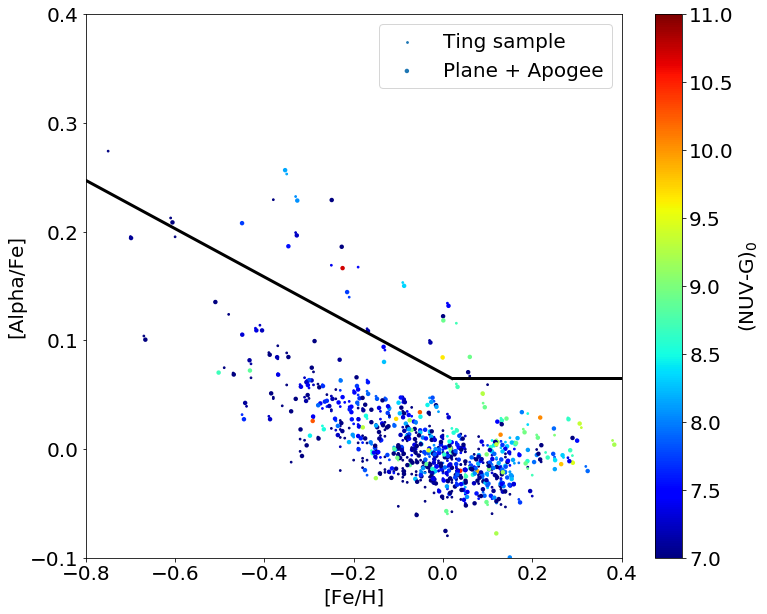

In [34]:
m = (0.265-0.065)/(-0.88-0.02)
b = 0.0694
xpfeh = np.linspace(-1, 0.02, 50)

plt.scatter(ting['Fe_H'], ting['alphafe'], c=(ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), s=3, vmin=7, vmax=11, cmap=cm.jet, label='Ting sample')
#plt.scatter(tais['Fe_H_1'], tais['alphafe'], c=(tais['nuv']-tais['ebv_1']*7.24)-(tais['phot_g_mean_mag_1']-tais['ebv_1']*2.85), s=50, vmin=7, vmax=11,edgecolor='violet', cmap=cm.jet, label='Plane+GAIS+Apogee')
plt.scatter(rc['FE_H'], rc['alphafe'], c=(rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85), s=20, vmin=7, vmax=11,edgecolor='none', cmap=cm.jet, label='Plane + Apogee')
plt.plot(xpfeh, xpfeh*m + b, c='black', linewidth=3)
plt.axhline(y=0.065, xmin=0.685, xmax=1, c='black', linewidth=3)
plt.xlim(-0.8, 0.4)
plt.ylim(-.1, 0.4)
plt.xlabel('[Fe/H]')
plt.ylabel('[Alpha/Fe]')
plt.colorbar().set_label('(NUV-G)$_0$')
plt.legend(scatterpoints=1, loc=1)
plt.show()

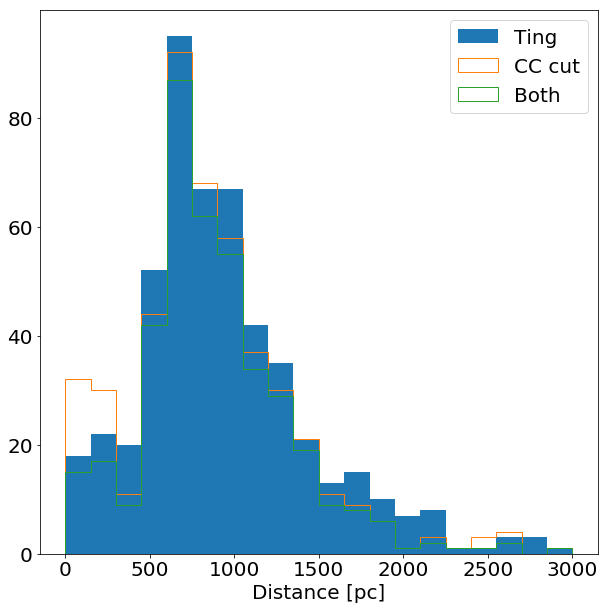

In [32]:
#plt.hist(rcais['dist'], bins=20, range=(0,3000), label='asdf')
plt.hist(ting['dist'], bins=20, range=(0,3000), label='Ting')
plt.hist(rc['dist'], bins=20, range=(0, 3000), histtype='step', fill=False, stacked=True, label='CC cut')
plt.hist(trc['dist_1'], bins=20, range=(0, 3000), histtype='step', fill=False, stacked=True, label='Both')
plt.xlabel('Distance [pc]')
plt.legend()
plt.show()

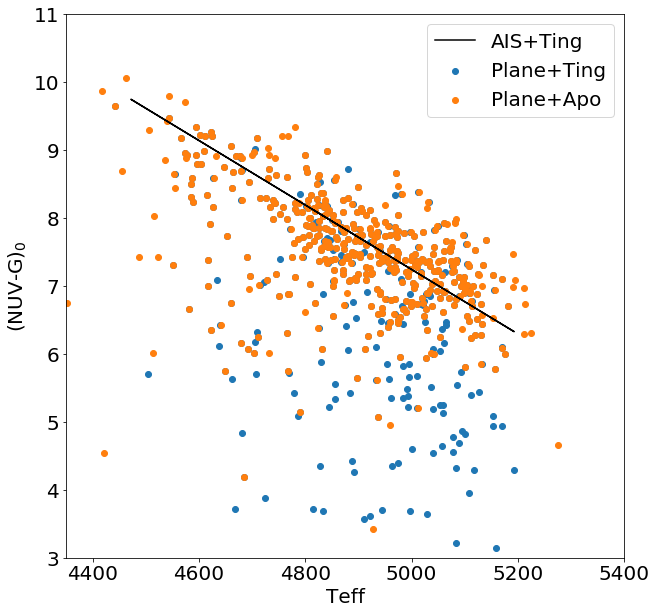

In [33]:
from scipy import stats
m = (0.265-0.065)/(-0.88-0.02)
b = 0.0694

y2 = (rcais['nuv_mag']-rcais['ebv']*7.24)-(rcais['phot_g_mean_mag']-rcais['ebv']*2.85)
x = rcais['TEFF']
m2, b2, rval2, pval2, stderr2 = stats.linregress(x, y2)
line2 = m2*x + b2
err2 = np.sqrt(np.sum((line2-y2)**2/len(y2)))


plt.scatter(ting['Teff'], (ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), label='Plane+Ting')
plt.scatter(rc['TEFF'], (rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85), label='Plane+Apo')
plt.plot(x, line2, c='black', label='AIS+Ting')
plt.xlim(4350, 5400)
plt.ylim(3, 11)
plt.xlabel('Teff')
plt.ylabel('(NUV-G)$_0$')
plt.legend()
plt.show()

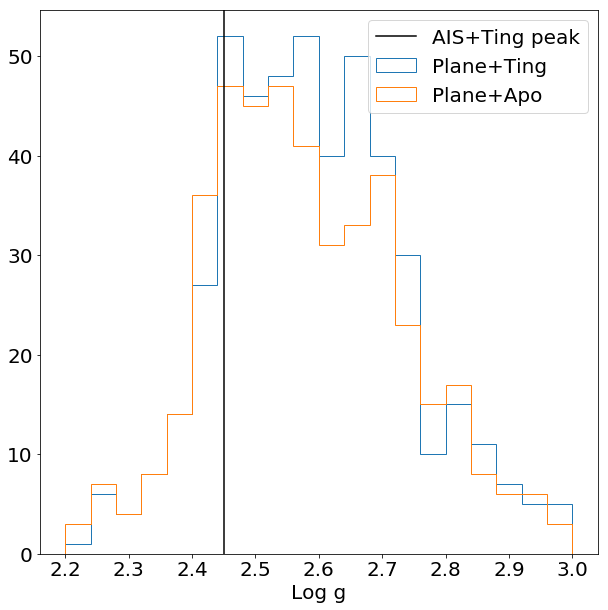

In [16]:
#plt.hist(rcais['logg'], range=[2.2, 3])
plt.hist(ting['Logg'], bins=20, range=[2.2, 3], histtype='step', fill=False,label='Plane+Ting')
plt.hist(rc['LOGG'], bins=20, range=[2.2, 3], histtype='step', fill=False, label='Plane+Apo')
plt.axvline(x=2.45, c='black', label='AIS+Ting peak')
plt.xlabel('Log g')
plt.legend()
plt.show()

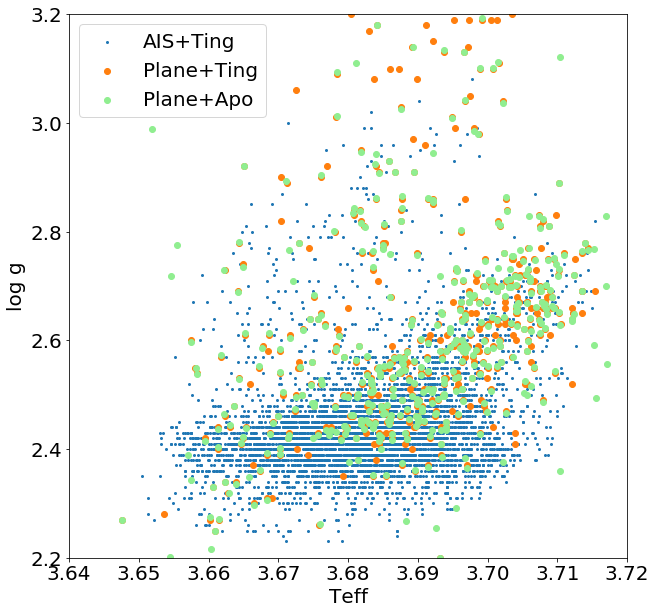

In [17]:
rc = rc[np.where(rc['LOGG'] > 0)]

plt.scatter(np.log10(rcais['teff']), rcais['logg'], s=4, label='AIS+Ting')#, c=ting['Fe_H'])
plt.scatter(np.log10(ting['Teff']), ting['Logg'], label='Plane+Ting')#, c=ting['Fe_H'])
plt.scatter(np.log10(rc['TEFF']), rc['LOGG'], c='lightgreen', label='Plane+Apo')#, c=rc['FE_H'])
plt.xlim(3.64, 3.72)
plt.ylim(2.2, 3.2)
plt.xlabel('Teff')
plt.ylabel('log g')
plt.legend()
plt.show()

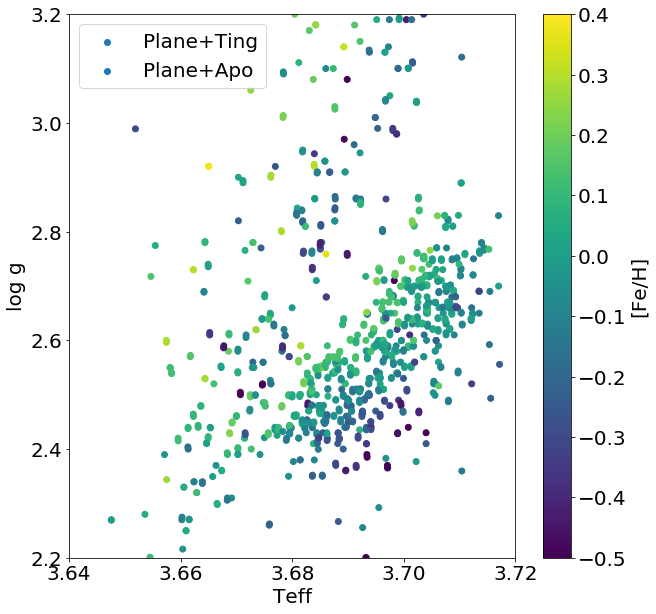

In [18]:
plt.scatter(np.log10(ting['Teff']), ting['Logg'], label='Plane+Ting', c=ting['Fe_H'], vmin=-0.5, vmax=0.4)
plt.scatter(np.log10(rc['TEFF']), rc['LOGG'], label='Plane+Apo', c=rc['FE_H'], vmin=-0.5, vmax=0.4)
plt.xlim(3.64, 3.72)
plt.ylim(2.2, 3.2)
plt.xlabel('Teff')
plt.ylabel('log g')
plt.colorbar().set_label('[Fe/H]')
plt.legend()
plt.show()

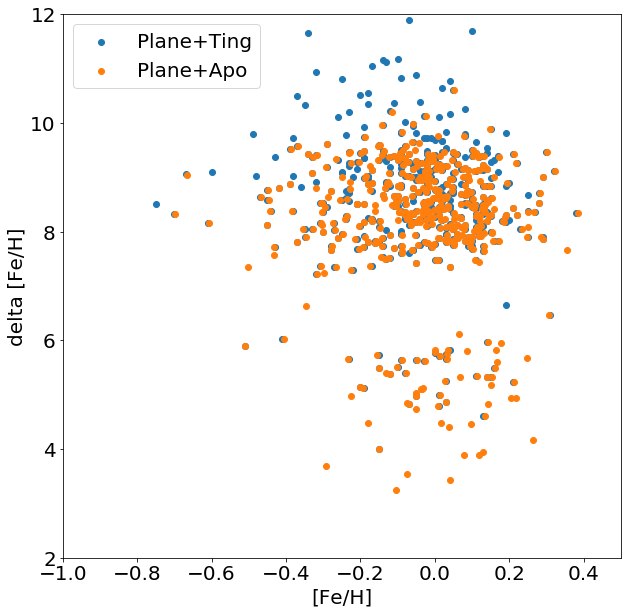

In [19]:
plt.scatter(ting['Fe_H'], ting['Fe_H'] - (0.16*(ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85) - 1.52*ting['alphafe'] - 1.47), label='Plane+Ting')

plt.scatter(rc['FE_H'], rc['FE_H'] - (0.16*(rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85) - 1.52*rc['alphafe'] - 1.47), label='Plane+Apo')
plt.xlabel('[Fe/H]')
plt.ylabel('delta [Fe/H]')
plt.xlim(-1, 0.5)
plt.ylim(2, 12)
plt.legend(loc=2)
plt.show()

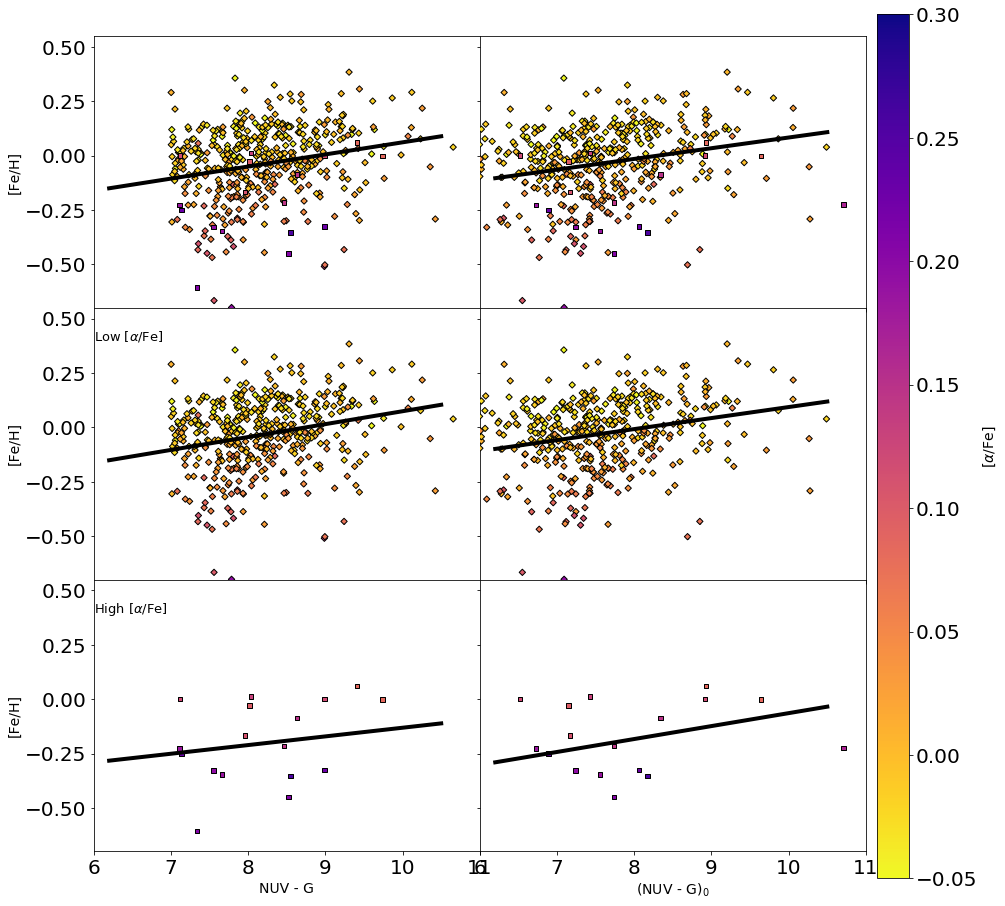

In [20]:
m = (0.265-0.065)/(-0.88-0.02)
b = 0.0694
thick,= np.where((rc['alphafe'] > 0.08) & (rc['alphafe'] > (m*rc['FE_H'] + b)))
thin,= np.where((rc['alphafe'] < 0.08) | (rc['alphafe'] < (m*rc['FE_H'] + b)))
 
thickfit = rc[thick]
thinfit = rc[thin]

# Key:
# a is not dust corrected. b is.

xa = rc['nuv']-rc['phot_g_mean_mag']
xb = (rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85)
y = rc['FE_H']

za, va = np.polyfit(xa, y, 1, cov=True)
zb, vb = np.polyfit(xb, y, 1, cov=True)
pa = np.poly1d(za)
pb = np.poly1d(zb)

aerr = np.sqrt(np.sum((pa(xa)-y)**2)/len(xa))
berr = np.sqrt(np.sum((pb(xb)-y)**2)/len(xb))

zathin, vathin = np.polyfit(xa[thin], y[thin], 1, cov=True)
zbthin, vbthin = np.polyfit(xb[thin], y[thin], 1, cov=True)
pathin = np.poly1d(zathin)
pbthin = np.poly1d(zbthin)
athinerr = np.sqrt(np.sum((pathin(xa[thin])-y[thin])**2)/len(xa[thin]))
bthinerr = np.sqrt(np.sum((pbthin(xb[thin])-y[thin])**2)/len(xb[thin]))

zathick, vathick = np.polyfit(xa[thick], y[thick], 1, cov=True)
zbthick, vbthick = np.polyfit(xb[thick], y[thick], 1, cov=True)
pathick = np.poly1d(zathick)
pbthick = np.poly1d(zbthick)
athickerr = np.sqrt(np.sum((pathick(xa[thick])-y[thick])**2)/len(xa[thick]))
bthickerr = np.sqrt(np.sum((pbthick(xb[thick])-y[thick])**2)/len(xb[thick]))

xp = np.linspace(6.2, 10.5, 50)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,figsize=(15, 15), sharex=True, sharey=True)

# Plotting with no dust correction first
# No dust, all points
cmap = ax1.scatter(xa[thin], y[thin], c=rc['alphafe'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax1.errorbar(xa[thin], y[thin], yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})


ax1.scatter(xa[thick], y[thick], c=rc['alphafe'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax1.errorbar(xa[thick], y[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})
ax1.plot(xp, pa(xp), linewidth=4, c='black', zorder=10) 

# Dust, all points
ax2.scatter(xb[thin], y[thin], c=rc['alphafe'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax2.errorbar(xb[thin], y[thin],yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax2.scatter(xb[thick], y[thick], c=rc['alphafe'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax2.errorbar(xb[thick], y[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax2.plot(xp, pb(xp), linewidth=4, c='black', zorder=10)

# No dust, thin disk
ax3.scatter(xa[thin], y[thin], c=rc['alphafe'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax3.errorbar(xa[thin], y[thin],yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})
ax3.plot(xp, pathin(xp), linewidth=4, c='black', zorder=10)

# Dust, thin disk
ax4.scatter(xb[thin], y[thin], c=rc['alphafe'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax4.errorbar(xb[thin], y[thin],yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})
ax4.plot(xp, pbthin(xp), linewidth=4, c='black', zorder=10)

# No dust, thick disk
ax5.scatter(xa[thick], y[thick], c=rc['alphafe'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax5.errorbar(xa[thick], y[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})
ax5.plot(xp, pathick(xp), linewidth=4, c='black', zorder=10)

# Dust, thick disk
ax6.scatter(xb[thick], y[thick], c=rc['alphafe'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax6.errorbar(xb[thick], y[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})
ax6.plot(xp, pbthick(xp), linewidth=4, c='black', zorder=10)

ax5.set_xlabel('NUV - G', fontsize=14)
ax6.set_xlabel('(NUV - G)$_{0}$', fontsize=14)
ax1.set_ylabel('[Fe/H]', fontsize=14)
ax3.set_ylabel('[Fe/H]', fontsize=14)
ax5.set_ylabel('[Fe/H]', fontsize=14)
#ax6.legend(scatterpoints=1, loc="lower right")
ax1.set_xlim(6, 11)
ax1.set_ylim(-.7,0.55)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(right=.84)
cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])

ax3.annotate(r'Low [$\alpha$/Fe]', xy=(6, 0.4), size=13)
ax5.annotate(r'High [$\alpha$/Fe]', xy=(6, 0.4), size=13)
fig.subplots_adjust(hspace=0, wspace=0)
fig.colorbar(cmap, cax=cbar_ax).set_label(r'[$\alpha$/Fe]', fontsize=14)
plt.show()


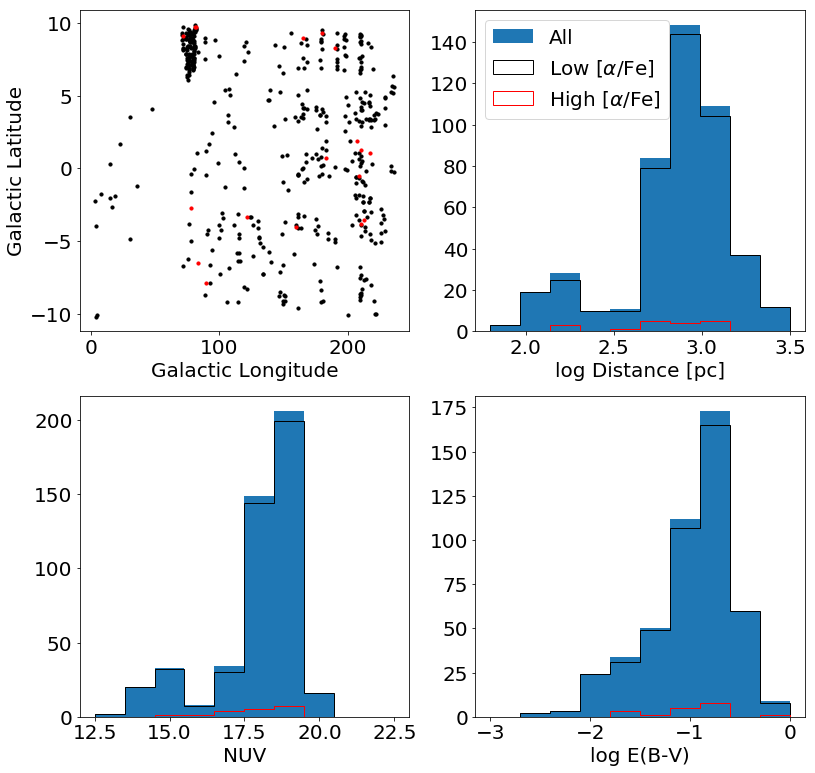

In [21]:
m = (0.265-0.065)/(-0.88-0.02)
b = 0.0694
thick,= np.where((rc['alphafe'] > 0.08) & (rc['alphafe'] > (m*rc['FE_H'] + b)))
thin,= np.where((rc['alphafe'] < 0.08) | (rc['alphafe'] < (m*rc['FE_H'] + b)))

thin = rc[thin]
thick = rc[thick]

fig, axes = plt.subplots(2, 2, figsize=(13,13))
axes[0, 0].scatter(thin['gl'], thin['gb'], c='black', s=10)
axes[0, 0].scatter(thick['gl'], thick['gb'], c='red', s=10)

axes[0, 1].hist(np.log10(rc['dist']), range=[1.8,3.5], label='All')
axes[0, 1].hist(np.log10(thin['dist']), range=[1.8,3.5], histtype='step', color='black', stacked=True, fill=False, label=r'Low [$\alpha$/Fe]')
axes[0, 1].hist(np.log10(thick['dist']), range=[1.8,3.5], histtype='step', color='red', stacked=True, fill=False, label=r'High [$\alpha$/Fe]')

axes[1, 0].hist(rc['nuv'], range=[12.5, 22.5])
axes[1, 0].hist(thin['nuv'],range=[12.5, 22.5], histtype='step', color='black', stacked=True, fill=False)
axes[1, 0].hist(thick['nuv'],range=[12.5, 22.5], histtype='step', color='red', stacked=True, fill=False)

axes[1, 1].hist(np.log10(rc['ebv']), range=[-3,0])
axes[1, 1].hist(np.log10(thin['ebv']), range=[-3,0], histtype='step', color='black', stacked=True, fill=False)
axes[1, 1].hist(np.log10(thick['ebv']), range=[-3,0], histtype='step', color='red', stacked=True, fill=False)

axes[0, 0].set_xlabel('Galactic Longitude')
axes[0, 0].set_ylabel('Galactic Latitude')
axes[0, 1].set_xlabel('log Distance [pc]')
axes[1, 0].set_xlabel('NUV')
axes[1, 1].set_xlabel('log E(B-V)')
axes[0, 1].legend(loc=2)
plt.show()

In [23]:
ps = fits.open('../plane_ps2_08_01_19.fits')[1].data
psgal = SkyCoord(ps['ALPHA_J2000']*u.deg, ps['DELTA_J2000']*u.deg, frame='icrs')
rcgal = SkyCoord(rc['ra_plane']*u.deg, rc['dec_plane']*u.deg, frame='icrs')
rcind, psind, angsep, a = search_around_sky(rcgal, psgal, 1*u.arcsec)

prc = hstack([rc[rcind], Table(ps[psind])])
prc.rename_column('nuv_1', 'nuv')
prc.rename_column('expsum_1', 'expsum')
prc.rename_column('ctsum_1', 'ctsum')
prc.rename_column('bkgdsum_1', 'bkgdsum')
prc.rename_column('gl_1', 'gl')
prc.rename_column('gb_1', 'gb')

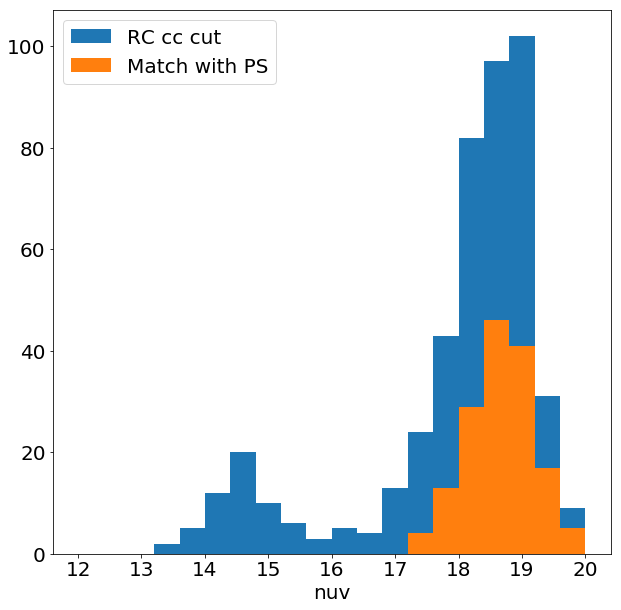

In [24]:
plt.hist(rc['nuv'], range=[12,20], bins=20, label='RC cc cut')
plt.hist(prc['nuv'], range=[12,20], bins=20, label='Match with PS')
plt.xlabel('nuv')
plt.legend(loc=2)
plt.show()

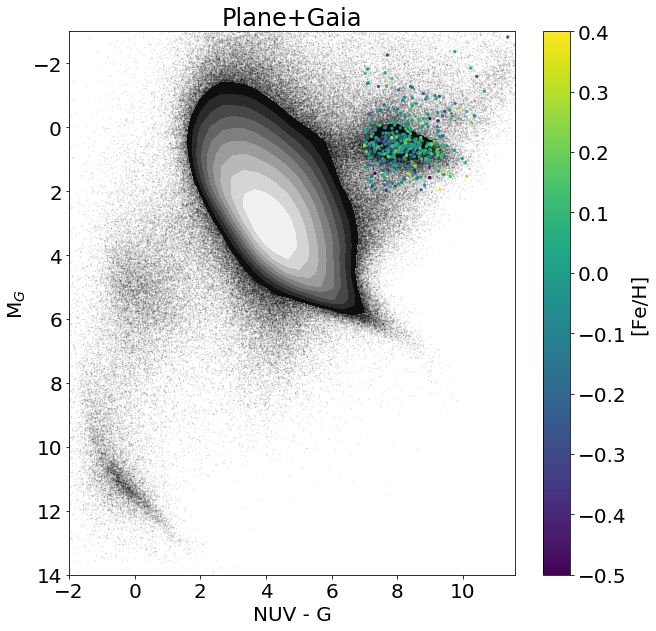

In [25]:
scatter_contour(cat['nuv']-cat['phot_g_mean_mag'], cat['phot_g_mean_mag']-cat['distmod'], threshold=1000, log_counts=True, histogram2d_args=dict(bins=40, range=[[-1,12], [-2,14]]), plot_args=dict(color='k', markersize=1, alpha=0.1), contour_args=dict(cmap=cm.gray, zorder=10))
plt.scatter(rc['nuv']-rc['phot_g_mean_mag'], rc['phot_g_mean_mag']-rc['distmod'], c=rc['FE_H'], vmin=-0.5, vmax=0.4, s=5, zorder=10)
plt.xlim((-2, 11.6))
plt.ylim((14, -3))
plt.colorbar().set_label('[Fe/H]')
plt.title('Plane+Gaia')
plt.xlabel('NUV - G')
plt.ylabel('M$_G$')
plt.show()

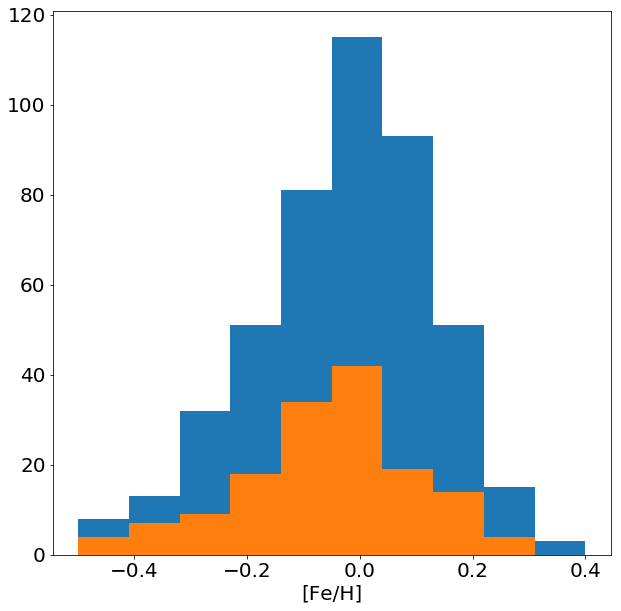

In [26]:
plt.hist(rc['FE_H'], range=[-0.5, 0.4])
plt.hist(prc['FE_H'], range=[-0.5, 0.4])
plt.xlabel('[Fe/H]')
plt.show()

In [27]:
cgp = fits.open('../plane_gaia_ps2_08_06_19.fits')[1].data

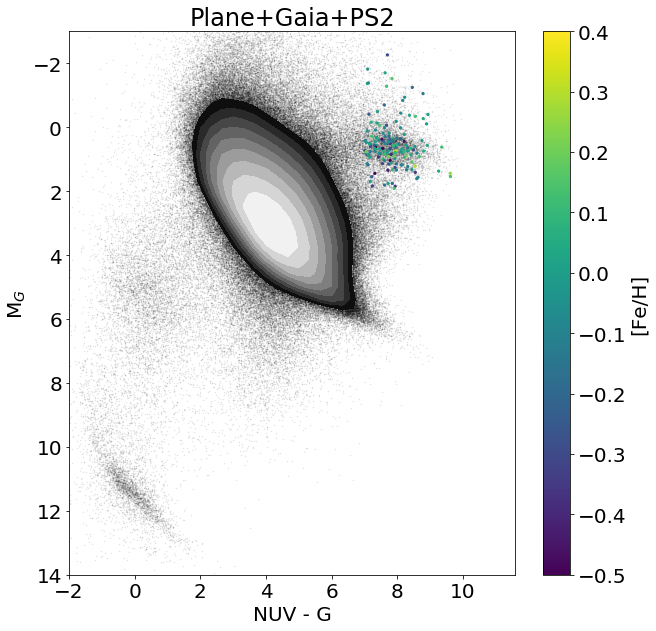

In [28]:
scatter_contour(cgp['nuv']-cgp['phot_g_mean_mag'], cgp['phot_g_mean_mag']-cgp['distmod'], threshold=1000, log_counts=True, histogram2d_args=dict(bins=40, range=[[-1,12], [-2,14]]), plot_args=dict(color='k', markersize=1, alpha=0.1), contour_args=dict(cmap=cm.gray, zorder=10))
plt.scatter(prc['nuv']-prc['phot_g_mean_mag'], prc['phot_g_mean_mag']-prc['distmod'], c=prc['FE_H'], vmin=-0.5, vmax=0.4, s=5, zorder=10)
plt.xlim((-2, 11.6))
plt.ylim((14, -3))
plt.colorbar().set_label('[Fe/H]')
plt.xlabel('NUV - G')
plt.ylabel('M$_G$')
plt.title('Plane+Gaia+PS2')
plt.show()

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


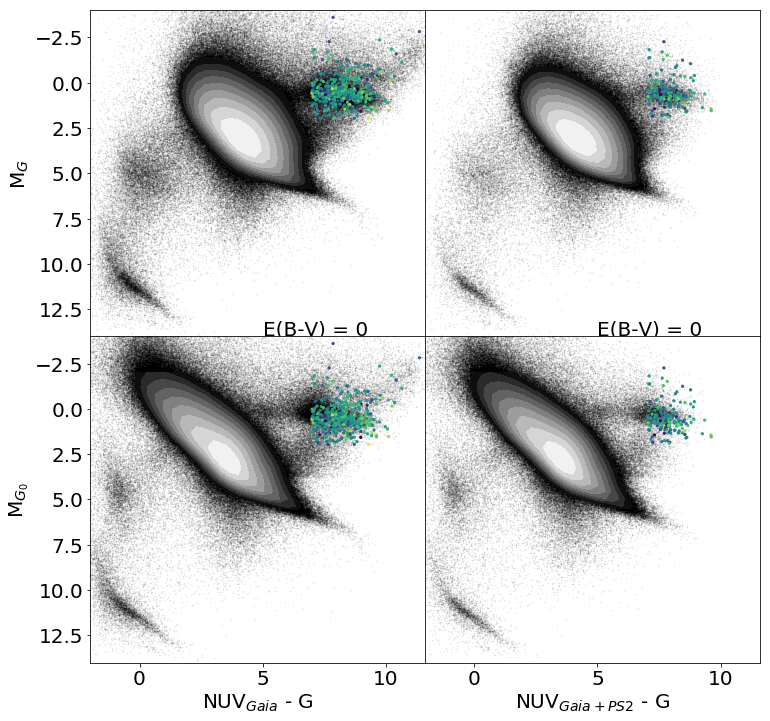

In [29]:
threshold = 1000
bins = 40

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

scatter_contour(cat['nuv']-cat['phot_g_mean_mag'], cat['phot_g_mean_mag']-cat['distmod'], threshold=threshold, log_counts=True, histogram2d_args=dict(bins=bins, range=[[-1,12], [-2,14]]), plot_args=dict(color='k', markersize=1, alpha=0.1), contour_args=dict(cmap=cm.gray, zorder=10), ax=axes[0, 0])

scatter_contour(cgp['nuv']-cgp['phot_g_mean_mag'], cgp['phot_g_mean_mag']-cgp['distmod'], threshold=threshold, log_counts=True, histogram2d_args=dict(bins=bins, range=[[-1,12], [-2,14]]), plot_args=dict(color='k', markersize=1, alpha=0.1), contour_args=dict(cmap=cm.gray, zorder=10), ax=axes[0, 1])

scatter_contour((cat['nuv']-cat['ebv']*7.24)-(cat['phot_g_mean_mag']-cat['ebv']*2.85), cat['phot_g_mean_mag']-cat['distmod']-cat['ebv']*2.85, threshold=threshold, log_counts=True, histogram2d_args=dict(bins=bins, range=[[-1,12], [-2,14]]), plot_args=dict(color='k', markersize=1, alpha=0.1), contour_args=dict(cmap=cm.gray, zorder=10), ax=axes[1, 0])

scatter_contour((cgp['nuv']-cgp['ebv']*7.24)-(cgp['phot_g_mean_mag']-cgp['ebv']*2.85), cgp['phot_g_mean_mag']-cgp['distmod']-cgp['ebv']*2.85, threshold=threshold, log_counts=True, histogram2d_args=dict(bins=bins, range=[[-1,12], [-2,14]]), plot_args=dict(color='k', markersize=1, alpha=0.1), contour_args=dict(cmap=cm.gray, zorder=10), ax=axes[1, 1])

axes[0, 0].scatter(rc['nuv']-rc['phot_g_mean_mag'], rc['phot_g_mean_mag']-rc['distmod'], c=rc['FE_H'], vmin=-0.5, vmax=0.4, s=5, zorder=10)

axes[0, 1].scatter(prc['nuv']-prc['phot_g_mean_mag'], prc['phot_g_mean_mag']-prc['distmod'], c=prc['FE_H'], vmin=-0.5, vmax=0.4, s=5, zorder=10)

axes[1, 0].scatter(rc['nuv']-rc['phot_g_mean_mag'], rc['phot_g_mean_mag']-rc['distmod'], c=rc['FE_H'], vmin=-0.5, vmax=0.4, s=5, zorder=10)

axes[1, 1].scatter(prc['nuv']-prc['phot_g_mean_mag'], prc['phot_g_mean_mag']-prc['distmod'], c=prc['FE_H'], vmin=-0.5, vmax=0.4, s=5, zorder=10)


axes[1, 0].set_xlabel('NUV$_{Gaia}$ - G')
axes[1, 1].set_xlabel('NUV$_{Gaia+PS2}$ - G')

axes[0, 0].set_ylabel('M$_G$')
axes[1, 0].set_ylabel('M$_{G_0}$')

axes[0, 0].text(5, 13.9, 'E(B-V) = 0')
axes[0, 1].text(5, 13.9, 'E(B-V) = 0')

axes[0, 0].set_xlim((-2, 11.6))
axes[0, 0].set_ylim((14, -4))
axes[1, 0].set_xlim((-2, 11.6))
axes[1, 0].set_ylim((14, -4))

axes[0, 1].set_xlim((-2, 11.6))
axes[0, 1].set_ylim((14, -4))
axes[1, 1].set_xlim((-2, 11.6))
axes[1, 1].set_ylim((14, -4))

axes[0, 0].set_xticks([])
axes[0, 1].set_yticks([])
axes[1, 1].set_yticks([])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show()